# Tehtävä 3-1

In [1]:
# Kirjoita tähän tietosi!
student_name = 'Iina Pirinen'  # Oma nimesi
student_id = 'AB7766' # Oma opiskelijatunnuksesi JAMK:ssa


### Aihe: Keras Functional API:n käyttö (2 p)

1. Luo alla olevan kuvan mukainen neuroverkko, jossa on useampi sisääntulo.
    * Kerroksien neuronien määrällä tai aktivointifunktiolla ei ole väliä, määritä ne itse vapaasti.
2. Aja "Tehtävän vastaukset" solu

Vinkkejä:
* Käytä `Concatenate`-kerrosta yhdistääksesi `Input2`- ja kolmas `Dense`-kerros vasemmalla kuvassa näkyvän Dense-kerroksen sisääntuloksi.
* Samoin käytä `Concatenate`-kerrosta yhdistääksesi `Input3`- ja kolmas `Dense`-kerros oikealla kuvassa näkyvän `Dense`-kerroksen sisääntuloksi.

* Vinkki: `Add`-kerroksen dokumentaatio: https://www.tensorflow.org/api_docs/python/tf/keras/layers/add?hl=th
Vinkki - koodihahmotelmaa mallin luomiseksi:
```
```

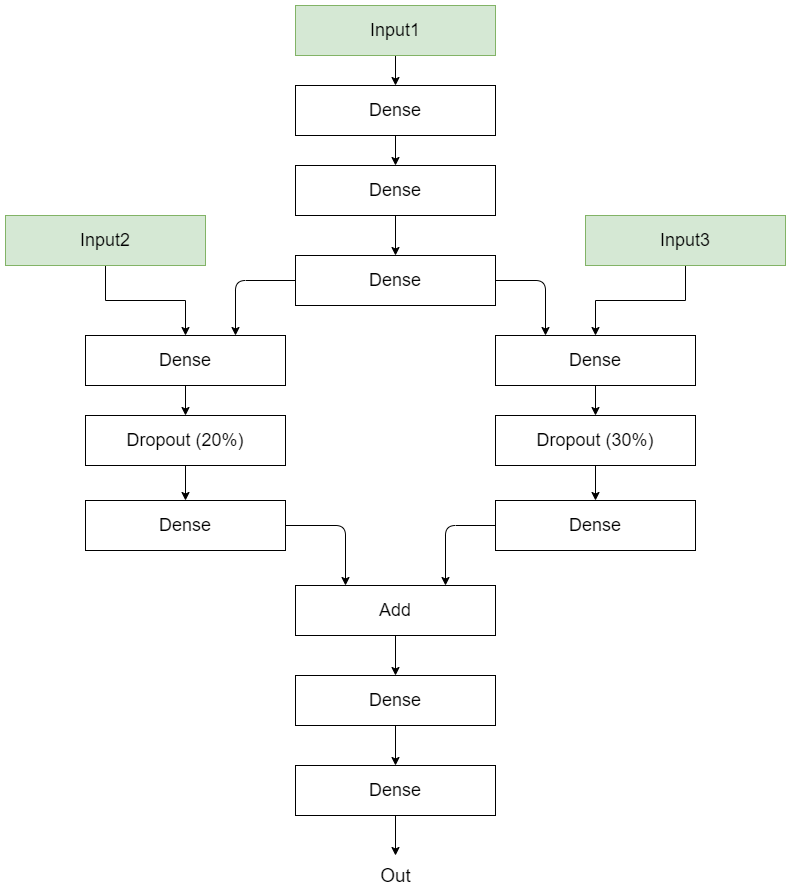

In [2]:
from IPython.display import Image
Image('../img/keras_functional_tehtava.png')

1. Input kerrokset

    Luodaan kolme syöttökerrosta, joista jokainen odottaa syötedataa, jonka muoto on (10,). Näitä käytetään kolmen eri syöttödatasarjan välittämiseen malliin.

2. Middle Dense Layers

    Kolme Dense kerrosta on yhdistetty peräkkäin. Jokaisessa kerroksessa on 8 yksikköä ja se käyttää oletuksena lineaarista aktivointitoimintoa.

3. Vasen haara

    input2:sta ketjutetaan viimeisen keskimmäisen Dense kerroksen lähtöön. Tämä ketjutettu tensori johdetaan sitten kahden muun Dense kerroksen läpi, joissa kummassakin on 8 yksikköä. Kahden Dense kerroksen väliin tulee pudotuskerros, jonka pudotusaste on 0,20.

4. Oikea haara
    
    Vasemman haaran tapaan input3:n tulo ketjutetaan viimeisen keskimmäisen Dense kerroksen lähtöön. Yhdistetty tensori johdetaan sitten kahden Dense kerroksen läpi, joissa kummassakin on 8 yksikköä. Kahden Dense kerroksen väliin tulee pudotuskerros, jonka pudotusaste on 0,30.

5. Vasemman ja oikean haaran yhdistäminen

    Vasemman ja oikean haaran viimeisten Dense kerrosten lähdöt lisätään elementtikohtaisesti.

6. Viimeiset Dense kerrokset

    Lisäyksestä saatuun summaan levitetään kaksi Dense lisäkerrosta. Lopullisessa tulostekerroksessa on 8 yksikköä.
    
7. Mallin kokoaminen

    Lopuksi luodaan Keras-malli määrittämällä tulot ja lähdöt.

In [3]:
# Tehtävän toteutus
import tensorflow as tf

# Input kerrokset
input1, input2, input3 = tf.keras.Input(shape=(10,)), tf.keras.Input(shape=(10,)), tf.keras.Input(shape=(10,))

# Keskimmäinen syöte
middle_dense1 = tf.keras.layers.Dense(8)(input1)
middle_dense2 = tf.keras.layers.Dense(8)(middle_dense1)
middle_dense3 = tf.keras.layers.Dense(8)(middle_dense2)

# vasen haara
left_concat = tf.keras.layers.concatenate([input2, middle_dense3])
left_dense1 = tf.keras.layers.Dense(8)(left_concat)
left_dropout = tf.keras.layers.Dropout(0.20)(left_dense1)
left_dense2 = tf.keras.layers.Dense(8)(left_dropout)

# oikea haara
right_concat = tf.keras.layers.concatenate([input3, middle_dense3])
right_dense1 = tf.keras.layers.Dense(8)(right_concat)
right_dropout = tf.keras.layers.Dropout(0.30)(right_dense1)
right_dense2 = tf.keras.layers.Dense(8)(right_dropout)

# yhdistetään vasen ja oikea haara Add-kerrokseen
add = tf.keras.layers.add([left_dense2, right_dense2])

# viimeiset Dense kerrokset
middle_dense4 = tf.keras.layers.Dense(8)(add)
out = tf.keras.layers.Dense(8)(middle_dense4)

# Sijoita luomasi malli model_functional - muuttujaan.
model_functional = tf.keras.Model(inputs=[input1, input2, input3], outputs=out)

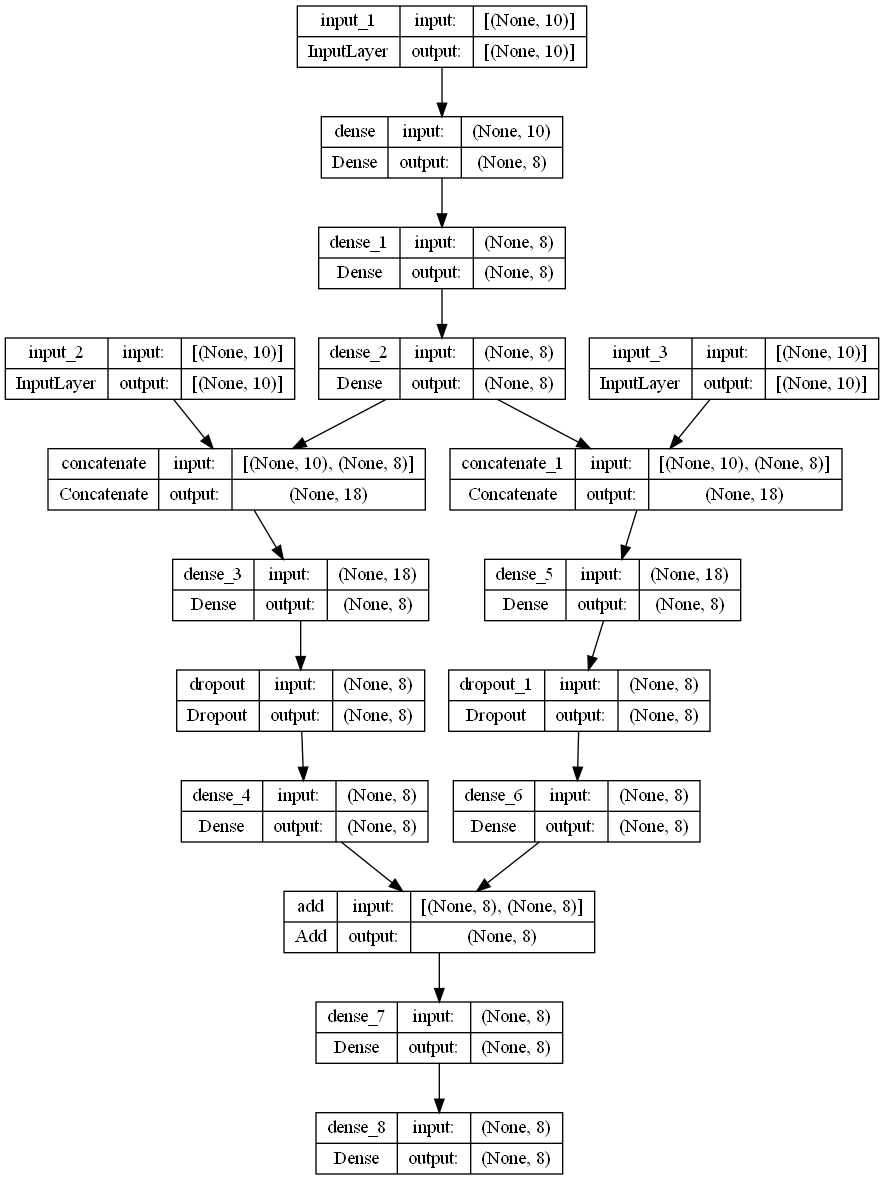

In [4]:
from tensorflow.keras.utils import plot_model

plot_model(model_functional, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. Sijoita luomasi malli model_functional - muuttujaan.

from IPython.display import SVG

# Piirretään kuva suoraan Notebook-dokumenttiin SVG-luokalla
svg = tf.keras.utils.model_to_dot(model_functional, dpi=70, show_shapes=True, expand_nested=True)
svg_img = SVG(svg.create(prog='dot', format='svg'))

In [6]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. Sijoita luomasi malli model_functional - muuttujaan.
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 8)            88          ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 8)            72          ['dense[0][0]']                  
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                              

# Tehtävä 3-2
### Aihe: Konvoluutioneuroverkko ja feature - matriisit (4 pistettä)

**Taustaa**

Conv2D-tasot muuttavat syöttökuvan matemaattikseki malliksi, jota tiiviisti kytketyt kerrokset käyttävät luokituksen (classification) luomiseen. Koska Dense-kerrokset voivat käsitellä vain 1D-dataa, ensin on muutettava viimeisen Conv2D-kerroksen antama moniulotteinen feature map 1D-muotoon Flatten-kerroksen avulla.

**Mallin konfigurointia** varten tarvitaan seuraavat tiedot:

* batch size arvoksi 50. Mallille syötetään 50 näytettä jokaisella askeleella.
* Kuvat ovat 32×32 pikselin kokoisia RGB-kuvia, ja ne asetetaan arvoihin (32, 32, 3)
* Häviöfunktio (loss function) on `sparse_categorical_crossentropy` ja `optimizer`-optimoija on `Adam()`
* Datassa olevia luokkia on 10.
* Epoch-kierrosten määrä on vain 5 iteraatiota. Reaalimäärässä kierroksia voi olla 50-100, mutta harjoitustehtävissä lisäkierroksista ei suuremmin ole hyötyä.
* Datasta 20% on testidataa. Loppu on opetusdataa.

**Syötedatan esikäsittely**:

* Muuta tiedot ennen neuroverkkoon sovittamista float32-formaattiin, minkä seurauksena koulutusprosessi on nopeampi GPU-prosessoinnissa.
* Tietojen skaalaaminen varmistaa, että painojen päivitykset ovat pienempiä, mikä parantaa lopputulostaa ja keventää datan prosessointia.

**Syväoppimismallin rakentaminen** (dokumentaatiota mukaillen):

When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers, does not include the sample axis). In the example inputs are 28x28 RGB images with `channels_last`:
>>> input_shape = (28, 28, 3)
>>> convLayer = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), activation='relu', input_shape=input_shape)

1. Tehtävässä määritetään kaksi `Conv2D`-kerrosta peräkkäisessä järjestyksessä (3×3 kernel size + ReLU-aktivointi) sekä niille suodatinmääriksi: 32 ja 64.
2. Seuraavaksi käytämme `Flatten`-kerrosta muuntamaan datan yksiulotteiseen muotoon.
3. Luokituksen luomiseen on kaksi `Dense`-kerrosta (suodatinten määrä 64 ja 10). Viimeinen kerros ei aktivoidu ReLU:lla, vaan Softmaxilla, jolloin saadaan moniluokkainen todennäköisyysjakauma vastauksena kysymykseen "mikä luokka on todennäköisin?".

**Mallin kokoaminen ja sovittaminen**
Syväoppimisen arkkitehtuurin tai kehyksen määrittelyn jälkeen voimme koota mallin ja sovittaa tiedot (eli aloittaa harjoittelun).

* Käännä malli
* sovita (*fit*) data malliin (`model.compile, model.fit`)
* arvioi mallin tulokset (`model.evaluate`) käyttäen erillistä testidataa.

**Arvioidaan ja tulostetaan:**
```
Test loss: ??? and Test accuracy: ???
```

In [7]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# Ladataan CIFAR-10 data
# cifar10.load_data()

# Syväoppimismallin luominen
# Skaalataan data parsimisen jälkeen (float32)

# Syväoppimismallin luominen
# model = Sequential()

# Mallin kääntäminen

# Sijoitetaan data malliin

In [8]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. 

# Tulostetaan  yhteenveto mallista sekä arviointimetriikka - poista kommentit ao. lauseista
# model.summary()
# score = model.evaluate(input_test, target_test, verbose=0)
# print(f'Loss: {score[0]} and accuracy: {score[1]}')

# Tehtävä 3-3
## Aihe: Uutisotsikoiden luokittelu RNN-mallin avulla (4 p)

Tässä luokitellaan dataa sillä perusteella, että onko kyseessä ns. klikkiotsikko vai ei.

Tehtävässä käytetään seuraavaa dataa:
[https://github.com/bhargaviparanjape/clickbait/tree/master/dataset](https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

### Perusalgoritmi tehtävän toteuttamiseen

1. Lataa aineisto **clickbait_data.txt** ja **non_clickbait_data.txt**-tiedostoista
2. Leimataan otsikot luokkaan (on klikkiotsikko  == 1 tai ei ole klikkiotsikko == 0)
2. Jaetaan data koulutus- ja testidataan (75% koulutusdataa ja 25% testidataa jako)
4. Luo RNN-malli, joka ennustaa, onko otsikko klikkiotsikko (clickbait) vai eikö se ole
5. Ennusta mallin tarkkuus `evaluate` - funktiolla

## Vinkkejä:
* Käytä numeeriseen muunnokseen `tf.keras.preprocessing.text.Tokenizer` - luokkaa
* Luo otsikoista samanpituiset sekvenssit: (`num_words=sanojen_määrä`)

### RNN ja LSTM

Recurrent neural networks (RNN) sopivat erityisen hyvin peräkkäisille tiedoille. Tunnettuja käytännön sovelluksia ovat mm. Googlen puhehaku ja Applen Siri.

* RNN sisältää sisäisen muistin.
* RNN on syväoppimisalgoritmi, joka voi muistaa syötteen.
* RNN:n sovelluksia ovat **LSTM** ja **GRU**
* RNN on suositeltu algoritmi peräkkäisille tiedoille, mm. kirjoitetulle tekstille, aikasarjoille, sääennusteille, taloustiedoille jne.

RNN:ssä data kiertää sisäisessä silmukassa. Kun RNN laskee output-kerroksen, se huomioi myös edellisen kerroksen ja myös sitä edeltävän kerroksen, koska sillä on lyhytaikainen muisti.

#### Tehtävän voi tehdä kahdella eri tavalla
Pisteitä annettaessa riittää, että on kuitenkin tehnyt toisella ao. tavoista:
1. SimpleRNN
2. LSTM - Tämä on suositeltavampi tapa tässä tehtävässä.

In [9]:
# Tehtävän toteutus

# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. Sijoita results - muuttujaan funktion model.evaluate() tulos.

# Muista määrittää model.compile() - funktioon seurattavaksi suureeksi metrics=['accuracy'], jotta näät, kuinka suuri osa neuroverkon ennustuksista on oikein.
print(f"Test Loss:{results[0]} Test Accuracy:{results[1]*100}%")

NameError: name 'results' is not defined